# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

# Load MNIST Handwritten Dataset

In [2]:
from torchvision import datasets 
from torchvision import transforms as T

In [3]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(),#convert image to tensor, it gives a new shape to the image, (chanel, height, width)
    T.Normalize(mean = 0.5, std=0.5)
])


valid_augs = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5)
])

In [4]:
#downloading the training and the testing datasets
trainset = datasets.MNIST('./',download=True, train = True, transform = train_augs)
testset = datasets.MNIST('./',download=True, train = False, transform = valid_augs)

In [5]:
#spliting into train and validation
trainset, validset = torch.utils.data.random_split(trainset,[50000, 10000])

In [6]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")
print(f"Size of testset : {len(testset)}")

Size of trainset : 50000
Size of validset : 10000
Size of testset : 10000


shape of image : torch.Size([1, 28, 28])
For visualization we need (h x w x c) so using permute shape will be : torch.Size([28, 28, 1])


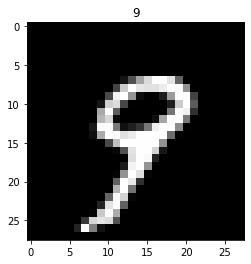

In [9]:
#visualizing an example image from the train set
idx = 45
image, label = trainset[idx]

print(f'shape of image : {image.shape}')

print(f'For visualization we need (h x w x c) so using permute shape will be : {image.permute(1, 2, 0).shape}')

plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
plt.title(label);

# Load Dataset into batches

In [10]:
from torch.utils.data import DataLoader

In [12]:
bs = 64 #batch size set to 64
trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)
validloader = DataLoader(validset, batch_size = bs)
testloader = DataLoader(testset, batch_size = bs)

In [13]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')
print(f'Total no. of batches in testloader : {len(testloader)}')

Total no. of batches in trainloader : 782
Total no. of batches in validloader : 157
Total no. of batches in testloader : 157


In [14]:
#printing the shape for labels and images in the batch
for images, labels in trainloader:
    print(f"One image batch shape: {images.shape}")
    print(f"One labesl batch shape: {labels.shape}")
    break

One image batch shape: torch.Size([64, 1, 28, 28])
One labesl batch shape: torch.Size([64])


# Load Model 

In [15]:
from models import DigitModel

model = DigitModel()
model.to('cpu')


DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

# Create Train and Eval Function

In [16]:
def train_fn(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    #Using tqdm to get the progression
    for images, labels in tqdm(dataloader):
        #Using 'cpu' becuase of cpu based environment, use cuda for a gpu device
        images = images.to('cpu')
        labels = labels.to('cpu')
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        #getting the gradients and updating the parameters from the model
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()
        total_acc +=utils.multiclass_accuracy(logits, labels)
        
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [17]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    
    with torch.no_grad():
    
        #Using tqdm to get the progression
        for images, labels in tqdm(dataloader):
            #Using 'cpu' becuase of cpu based environment, use cuda for a gpu device
            images = images.to('cpu')
            labels = labels.to('cpu')

            logits = model(images)
            loss = criterion(logits, labels)
            total_loss+=loss.item()
            total_acc +=utils.multiclass_accuracy(logits, labels)

        return total_loss / len(dataloader), total_acc / len(dataloader)

# Training Loop 

In [18]:
criterion = torch.nn.CrossEntropyLoss()
#using adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [19]:
best_valid_loss = np.Inf

#Taking an Epoch as 7 
for i in range(7):
    train_loss, train_acc = train_fn(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = eval_fn(model, trainloader, criterion)
    print(f"Epoch {i+1} Train Loss: {train_loss} Train Accuracy: {train_acc}")
    print(f"Epoch {i+1} Validation Loss: {valid_loss} Validation Accuracy: {valid_acc}")
    
    #saving the best model state based on valid_loss
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),"best_weights.pt")
        print("SAVED_BEST_MODEL")
        best_valid_loss = valid_loss
        

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.7577968581443857 Train Accuracy: 0.7397897839546204
Epoch 1 Validation Loss: 0.28767065535230407 Validation Accuracy: 0.9104459881782532
SAVED_BEST_MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.36763879430034885 Train Accuracy: 0.8868885636329651
Epoch 2 Validation Loss: 0.1764595169488274 Validation Accuracy: 0.9462515711784363
SAVED_BEST_MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.28381006467773023 Train Accuracy: 0.9136428833007812
Epoch 3 Validation Loss: 0.16875533677656632 Validation Accuracy: 0.9499480724334717
SAVED_BEST_MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.24167479647090062 Train Accuracy: 0.9273697137832642
Epoch 4 Validation Loss: 0.12996961379333224 Validation Accuracy: 0.9592191576957703
SAVED_BEST_MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.22542284198029114 Train Accuracy: 0.9322450160980225
Epoch 5 Validation Loss: 0.11350884017489297 Validation Accuracy: 0.966232419013977
SAVED_BEST_MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.20951119243212596 Train Accuracy: 0.9366008639335632
Epoch 6 Validation Loss: 0.10291882765019679 Validation Accuracy: 0.9693294167518616
SAVED_BEST_MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.20253359438503718 Train Accuracy: 0.9388986825942993
Epoch 7 Validation Loss: 0.10421103717821181 Validation Accuracy: 0.9688299298286438


# Inference

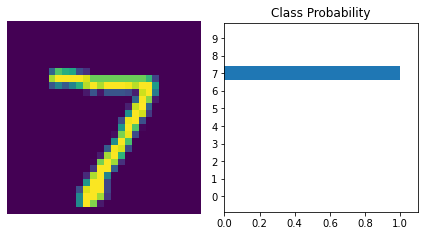

In [23]:
image, label = testset[0]
weights = torch.load('best_weights.pt')
model.load_state_dict(weights)

model.eval()
with torch.no_grad():
    #we are adding an index aloingside channel, height and width
    logits = model(image.unsqueeze(0))
    #applying softmax activation function to the raw outputs
    ps = torch.nn.Softmax(dim =1)(logits)[0] #probabilities
    utils.view_classify(image, ps)